In [10]:
import pandas
import konlpy
import gensim


print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


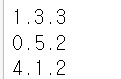

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.head())

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


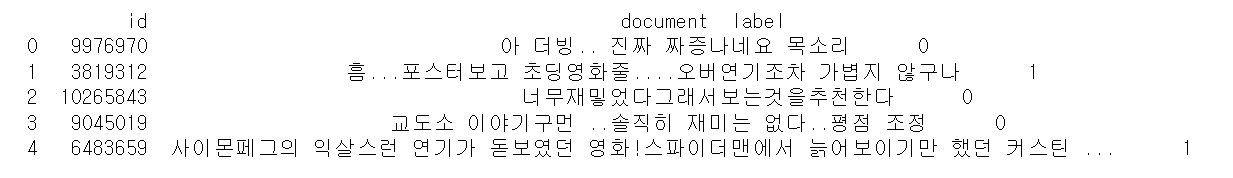

In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=200000):
    # 중복/결측치 처리
    train_data = train_data.drop_duplicates(subset=['document']).dropna()
    test_data = test_data.drop_duplicates(subset=['document']).dropna()
    
    # 토큰화 및 불용어 처리 (수정 부분)
    def tokenize(text):
        tokens = tokenizer.morphs(str(text))
        return [word for word in tokens if word not in stopwords] or ['<UNK>']
    #토큰화 적용
    X_train = [tokenize(text) for text in train_data['document']]
    X_test = [tokenize(text) for text in test_data['document']]
    
    # 사전 구성
    counter = Counter(word for tokens in X_train for word in tokens if word != '<UNK>')
    word_to_index = {
        '<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '<UNUSED>': 3
    }
    for idx, (word, count) in enumerate(counter.most_common(num_words-4), start=4):
        word_to_index[word] = idx

    
    index_to_word = {idx: word for word, idx in word_to_index.items()}


    
    # 텍스트를 인덱스로 변환
    X_train = [[word_to_index.get(word, 2) for word in tokens] for tokens in X_train]
    X_test = [[word_to_index.get(word, 2) for word in tokens] for tokens in X_test]

    return X_train, train_data['label'].values, X_test, test_data['label'].values, word_to_index, index_to_word

X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data(train_data, test_data)

#데이터 확인
print(10 in index_to_word)

# 모든 인덱스가 연속적인지 확인 (0~max_index)
max_index = max(index_to_word.keys())
for i in range(0, max_index + 1):
    assert i in index_to_word, f"인덱스 {i} 누락됨"

True


In [14]:
print('X_train 길이:', len(X_train))
print('y_train 길이:', len(y_train))
print('X_test 길이:', len(X_test))
print('y_test 길이:', len(y_test))

print("word_to_index 타입:", type(word_to_index))
print("단어 사전 크기:", len(word_to_index))

# 토큰화 및 불용어 제거 후 샘플 5개 출력
for i in range(5):
    print(X_train[i])

#이상치 확인
empty_count = sum(1 for tokens in X_train if len(tokens) == 0)
print('빈 문장 개수:', empty_count)

#원본과 전처리 비교
for i in range(5):
    print('원본:', train_data['document'].iloc[i])
    print('전처리:', X_train[i])
    print()

X_train 길이: 146182
y_train 길이: 146182
X_test 길이: 49157
y_test 길이: 49157
word_to_index 타입: <class 'dict'>
단어 사전 크기: 53965
[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
[24, 205, 30114]
[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
[22673, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 16052, 22674, 427, 3102, 1766, 6]
빈 문장 개수: 0
원본: 아 더빙.. 진짜 짜증나네요 목소리
전처리: [32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

원본: 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
전처리: [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]

원본: 너무재밓었다그래서보는것을추천한다
전처리: [24, 205, 30114]

원본: 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
전처리: [8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]

원본: 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
전처리: [22673, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 16052, 22674, 427, 3102, 1766, 6]



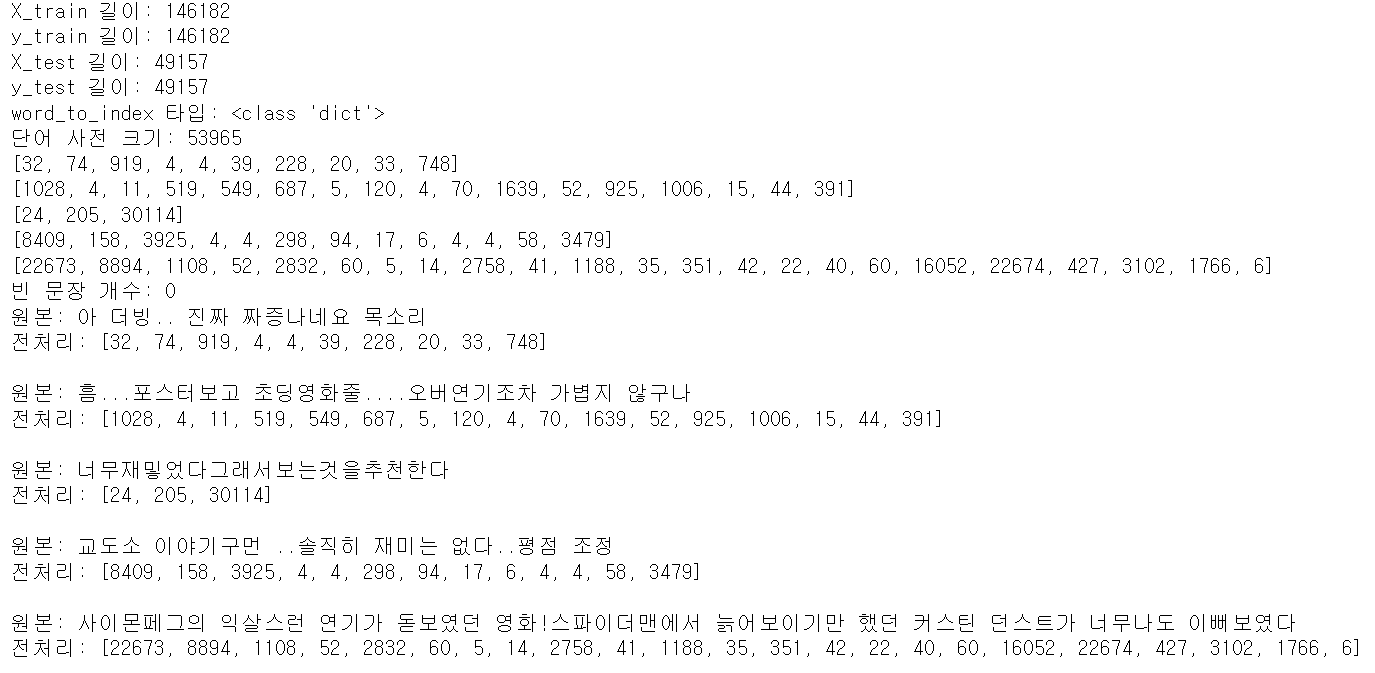

예시답안

index_to_word = {index:word for word, index in word_to_index.items()}

 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  [1:]를 통해 <BOS>를 제외

 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [15]:
# === 3. 데이터 분석 및 패딩 ===
# 문장 길이 분석
all_data = X_train + X_test
num_tokens = np.array([len(tokens) for tokens in all_data])
maxlen = int(np.mean(num_tokens) + 2 * np.std(num_tokens))

print("\n=== 문장 길이 분석 ===")
print(f"평균: {np.mean(num_tokens):.1f}, 최대: {np.max(num_tokens)}, 패딩 길이: {maxlen}")

#적절한 최대 문장 길이 지정과 keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 패딩 적용
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, maxlen=maxlen, padding='post', value=word_to_index['<PAD>'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(
    X_test, maxlen=maxlen, padding='post', value=word_to_index['<PAD>'])

print(X_train.shape)


=== 문장 길이 분석 ===
평균: 16.0, 최대: 116, 패딩 길이: 41
(146182, 41)


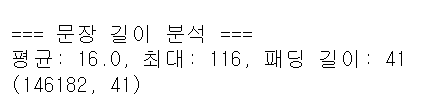

In [ ]:
# === 4. 모델 구성 및 검증 데이터 분리 ===
# 검증 데이터 분리
val_size = 10000
x_val, y_val = X_train[:val_size], y_train[:val_size]
x_train_partial, y_train_partial = X_train[val_size:], y_train[val_size:]
from sklearn.model_selection import train_test_split


#모델구성
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, GRU, GlobalAveragePooling1D, Dense

vocab_size = len(word_to_index)
word_vector_dim = 128 

#  CNN 모델
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=maxlen),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#  LSTM 모델
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=maxlen),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#  FFNN(DAN) 모델
model_ffnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=maxlen),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])
model_ffnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 모델 요약 출력
print("=== CNN 모델 구조 ===")
model_cnn.summary()
print("=== LSTM 모델 구조 ===")
model_lstm.summary()
print("=== FFNN(DAN) 모델 구조 ===")
model_ffnn.summary()

=== CNN 모델 구조 ===
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 128)           6907520   
_________________________________________________________________
conv1d (Conv1D)              (None, 37, 64)            41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 6,948,609
Trainable params: 6,948,609
Non-trainable params: 0
_________________________________________________________________
=== LSTM 모델 구조 ===
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 128)         

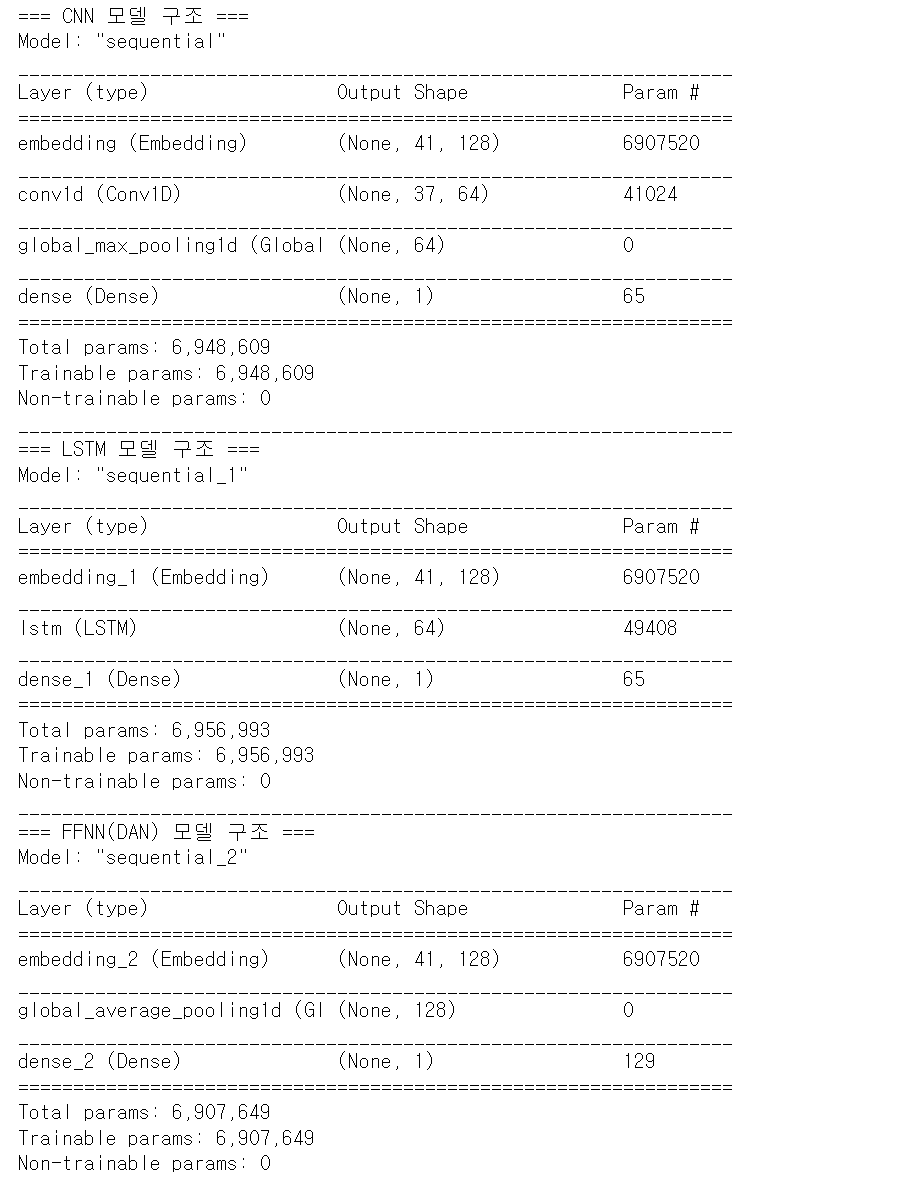

In [17]:
# === 5.모델 훈련 ===
models = [model_cnn, model_lstm, model_ffnn]
model_names = ['CNN', 'LSTM', 'FFNN']
histories = {}
results = {}

for model, name in zip(models, model_names):
    print(f"\n=== {name} 모델 훈련 시작 ===")
    
    # 훈련 (검증 데이터 포함)
    history = model.fit(
        x_train_partial, y_train_partial,
        epochs=10,
        batch_size=512,
        validation_data=(x_val, y_val),
        verbose=1
    )
    histories[name] = history
    
    # 테스트 평가
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    results[name] = {'loss': test_loss, 'accuracy': test_acc}
    print(f"{name} 테스트 정확도: {test_acc:.4f}")


=== CNN 모델 훈련 시작 ===
Epoch 1/10
266/266 [==============================] - 67s 10ms/step - loss: 0.4186 - accuracy: 0.8095 - val_loss: 0.3329 - val_accuracy: 0.8549
Epoch 2/10
266/266 [==============================] - 2s 8ms/step - loss: 0.2841 - accuracy: 0.8849 - val_loss: 0.3260 - val_accuracy: 0.8564
Epoch 3/10
266/266 [==============================] - 2s 8ms/step - loss: 0.2184 - accuracy: 0.9172 - val_loss: 0.3423 - val_accuracy: 0.8525
Epoch 4/10
266/266 [==============================] - 2s 8ms/step - loss: 0.1644 - accuracy: 0.9408 - val_loss: 0.3803 - val_accuracy: 0.8515
Epoch 5/10
266/266 [==============================] - 2s 8ms/step - loss: 0.1226 - accuracy: 0.9577 - val_loss: 0.4195 - val_accuracy: 0.8472
Epoch 6/10
266/266 [==============================] - 2s 8ms/step - loss: 0.0914 - accuracy: 0.9698 - val_loss: 0.4612 - val_accuracy: 0.8481
Epoch 7/10
266/266 [==============================] - 2s 8ms/step - loss: 0.0691 - accuracy: 0.9786 - val_loss: 0.5108 - val

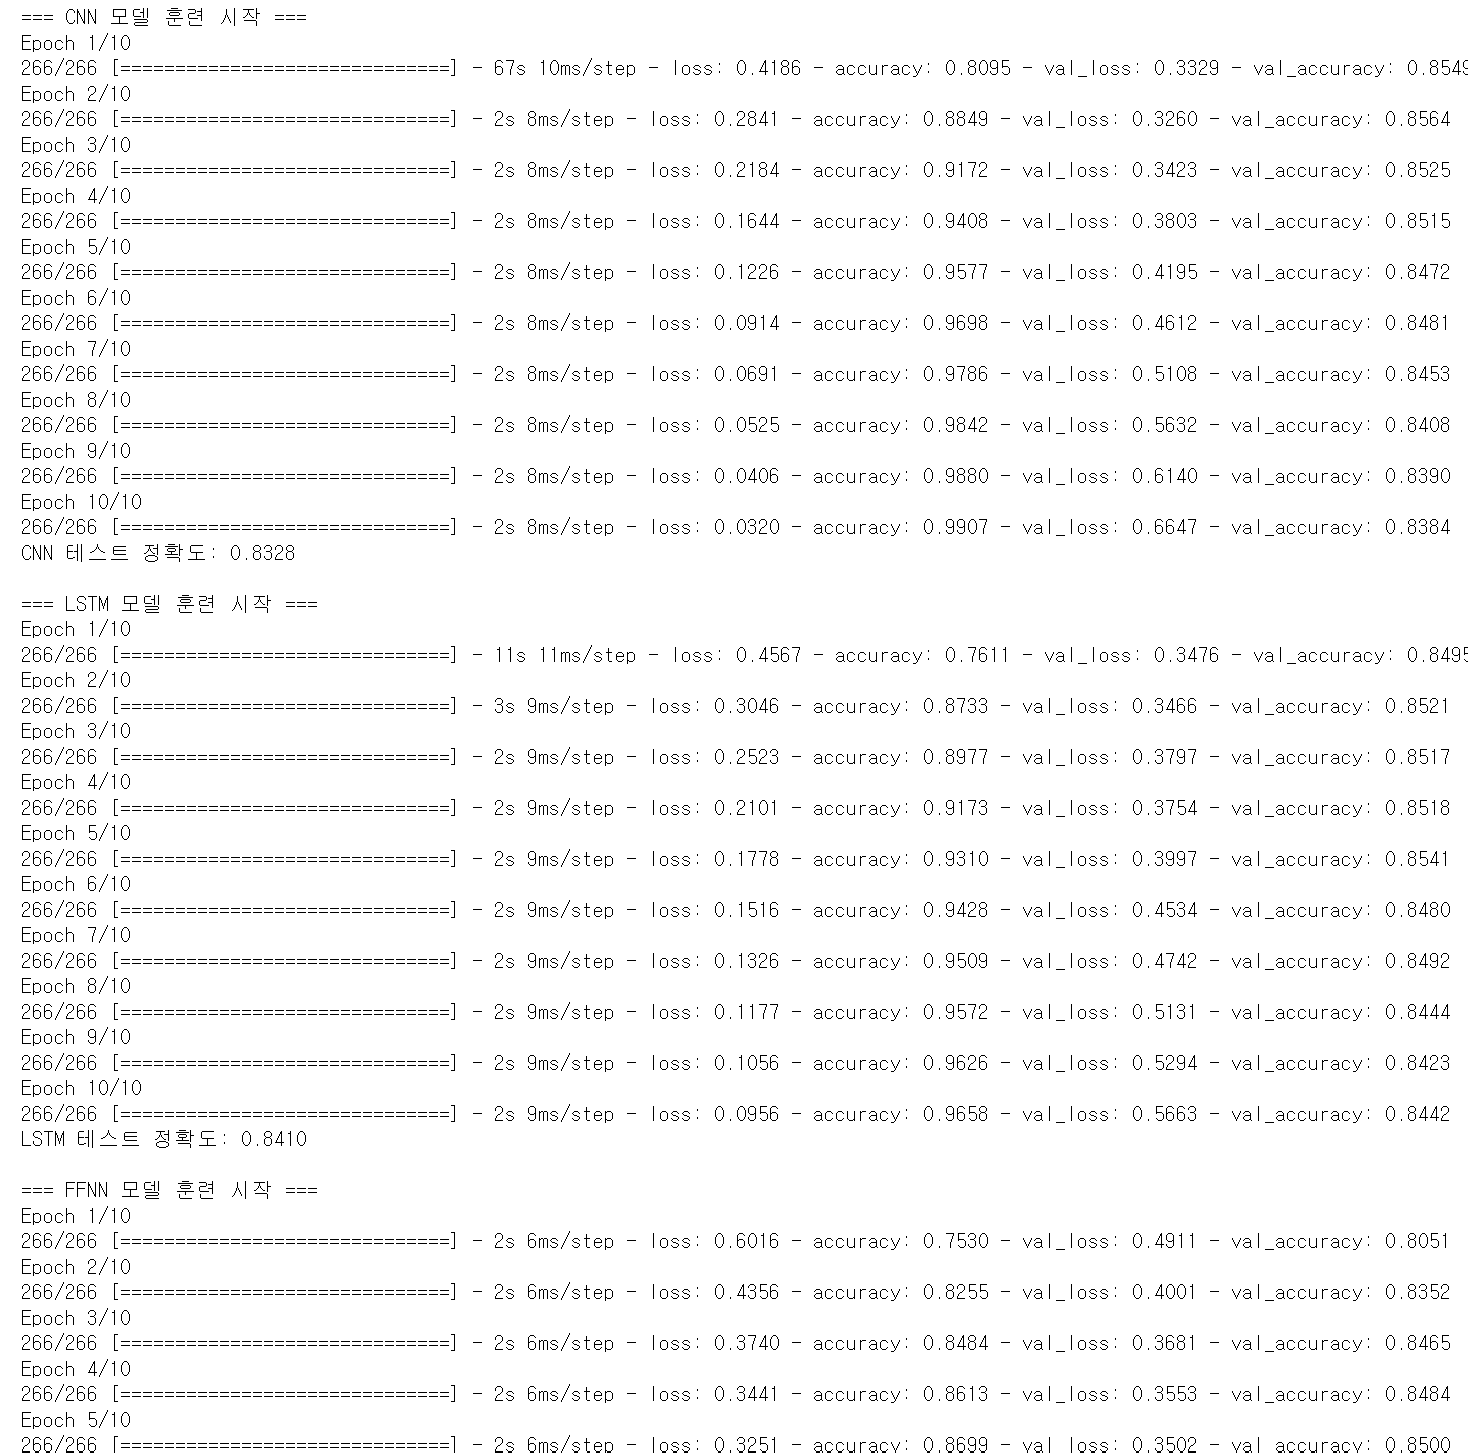

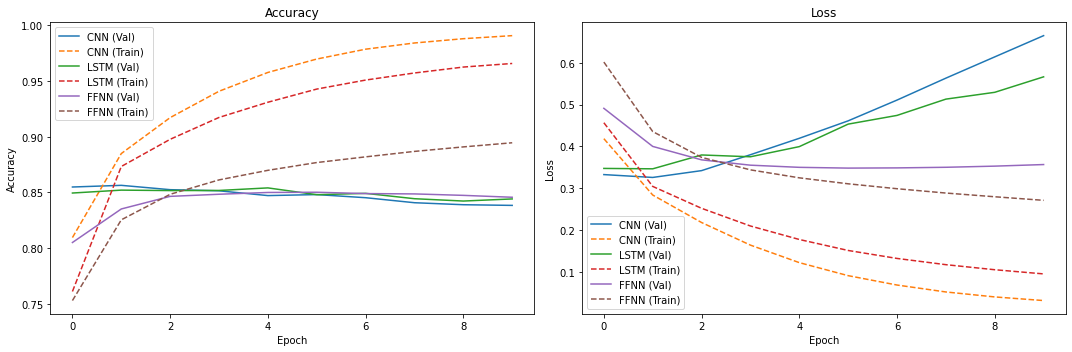


=== 최종 테스트 성능 ===
CNN:
  Loss: 0.6840
  Accuracy: 0.8328

LSTM:
  Loss: 0.5793
  Accuracy: 0.8410

FFNN:
  Loss: 0.3725
  Accuracy: 0.8462



In [18]:
# === 6. Loss/Accuracy 시각화 ===
plt.figure(figsize=(15,5))

# 정확도 곡선
plt.subplot(1,2,1)
for name in model_names:
    plt.plot(histories[name].history['val_accuracy'], label=f'{name} (Val)')
    plt.plot(histories[name].history['accuracy'], linestyle='--', label=f'{name} (Train)')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 곡선
plt.subplot(1,2,2)
for name in model_names:
    plt.plot(histories[name].history['val_loss'], label=f'{name} (Val)')
    plt.plot(histories[name].history['loss'], linestyle='--', label=f'{name} (Train)')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("\n=== 최종 테스트 성능 ===")
for name in model_names:
    print(f"{name}:")
    print(f"  Loss: {results[name]['loss']:.4f}")
    print(f"  Accuracy: {results[name]['accuracy']:.4f}\n")

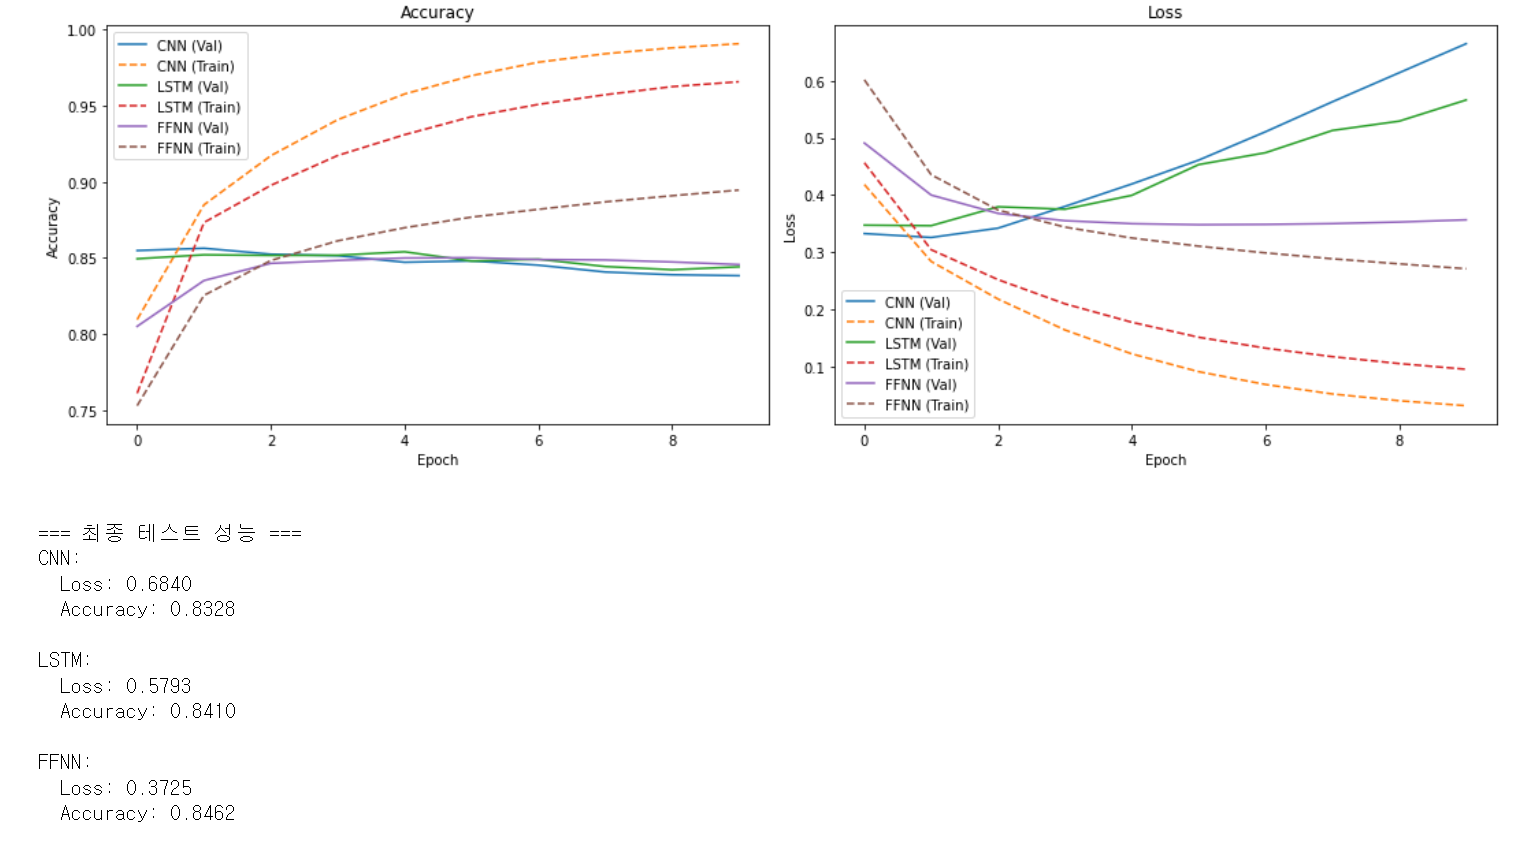

In [29]:
from gensim.models import KeyedVectors
# 분석할 모델들을 리스트로 지정
target_models = [model_cnn, model_lstm, model_ffnn]

# 각 모델의 임베딩 레이어 분석
for i, model in enumerate(target_models, 1):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    print(f"Model {i} 임베딩 차원:", weights.shape)   # shape: (vocab_size, embedding_dim)

Model 1 임베딩 차원: (53965, 128)
Model 2 임베딩 차원: (53965, 128)
Model 3 임베딩 차원: (53965, 128)


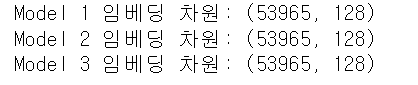

In [43]:
# ===7 학습된 Embedding 레이어 분석 ===
#load() 형태로 모델을 불러옴
from gensim.models import KeyedVectors
import numpy as np
import os

# 1. 임베딩 레이어에서 가중치 추출
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print("임베딩 가중치 shape:", weights.shape)

# 2. KeyedVectors 객체 생성
word_vectors = KeyedVectors(vector_size=weights.shape[1])

# 3. 단어와 벡터 매핑 (특수 토큰 0~3 제외)
words = []
vectors = []
for i in range(4, len(word_to_index)):  # '<PAD>', '<BOS>', '<UNK>', '<UNUSED>' 제외
    word = index_to_word[i]
    vector = weights[i]
    words.append(word)
    vectors.append(vector)

# 4. 
word_vectors.add_vectors(keys=words, weights=np.array(vectors))

# 5. 모델 저장
save_path = os.path.join(os.getenv('HOME'), 'aiffel/sentiment_classification/data/last_word2vec.model')
word_vectors.save(save_path)
print(f"임베딩 저장 완료: {save_path}")

# 6. 로드 테스트
loaded_vectors = KeyedVectors.load(save_path)
print("'영화' :", loaded_vectors['영화'][:5])
print("'최고'와 유사한 단어:", loaded_vectors.most_similar('최고', topn=3))


임베딩 가중치 shape: (53965, 128)
임베딩 저장 완료: /aiffel/aiffel/sentiment_classification/data/last_word2vec.model
'영화' : [ 0.00031988  0.05718287  0.08211186 -0.02006444  0.07268144]
'최고'와 유사한 단어: [('♥', 0.9978744983673096), ('여운', 0.9973096251487732), ('명작', 0.997122049331665)]


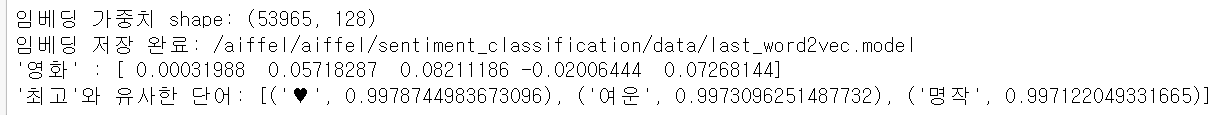

In [ ]:
#=== 한국어 Word2Vec 임베딩 활용하여 성능 개선 ===
from gensim.models import Word2Vec
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2Vec.load(word2vec_path).wv
embedding_dim = word2vec.vector_size
vocab_size = len(word_to_index)

embedding_matrix = np.random.randn(vocab_size, embedding_dim)
for word, idx in word_to_index.items():
    if word in word2vec:
        embedding_matrix[idx] = word2vec[word]

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    x_train_partial, y_train_partial,
    epochs=10, batch_size=512,
    validation_data=(x_val, y_val)
)
results = model.evaluate(X_test, y_test, verbose=2)
print("테스트셋 성능:", results)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           5396500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,438,805
Trainable params: 5,438,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
266/266 [==============================] - 4s 10ms/step - loss: 0.5431 - accuracy: 0.7050 - val_loss: 0.4212 - val_accuracy: 0.8092
Epoch 2/10
266/266 [==============================] - 2s 8ms/step - loss: 0.3735 - accuracy: 0.8338 - val_loss: 0.3546 - val_accuracy: 0.8453
Epoch 3/10
266/266 [==============================] - 2s 8ms/step - loss: 0.3137 - accura

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'int\'>"})'}), <class 'numpy.ndarray'>

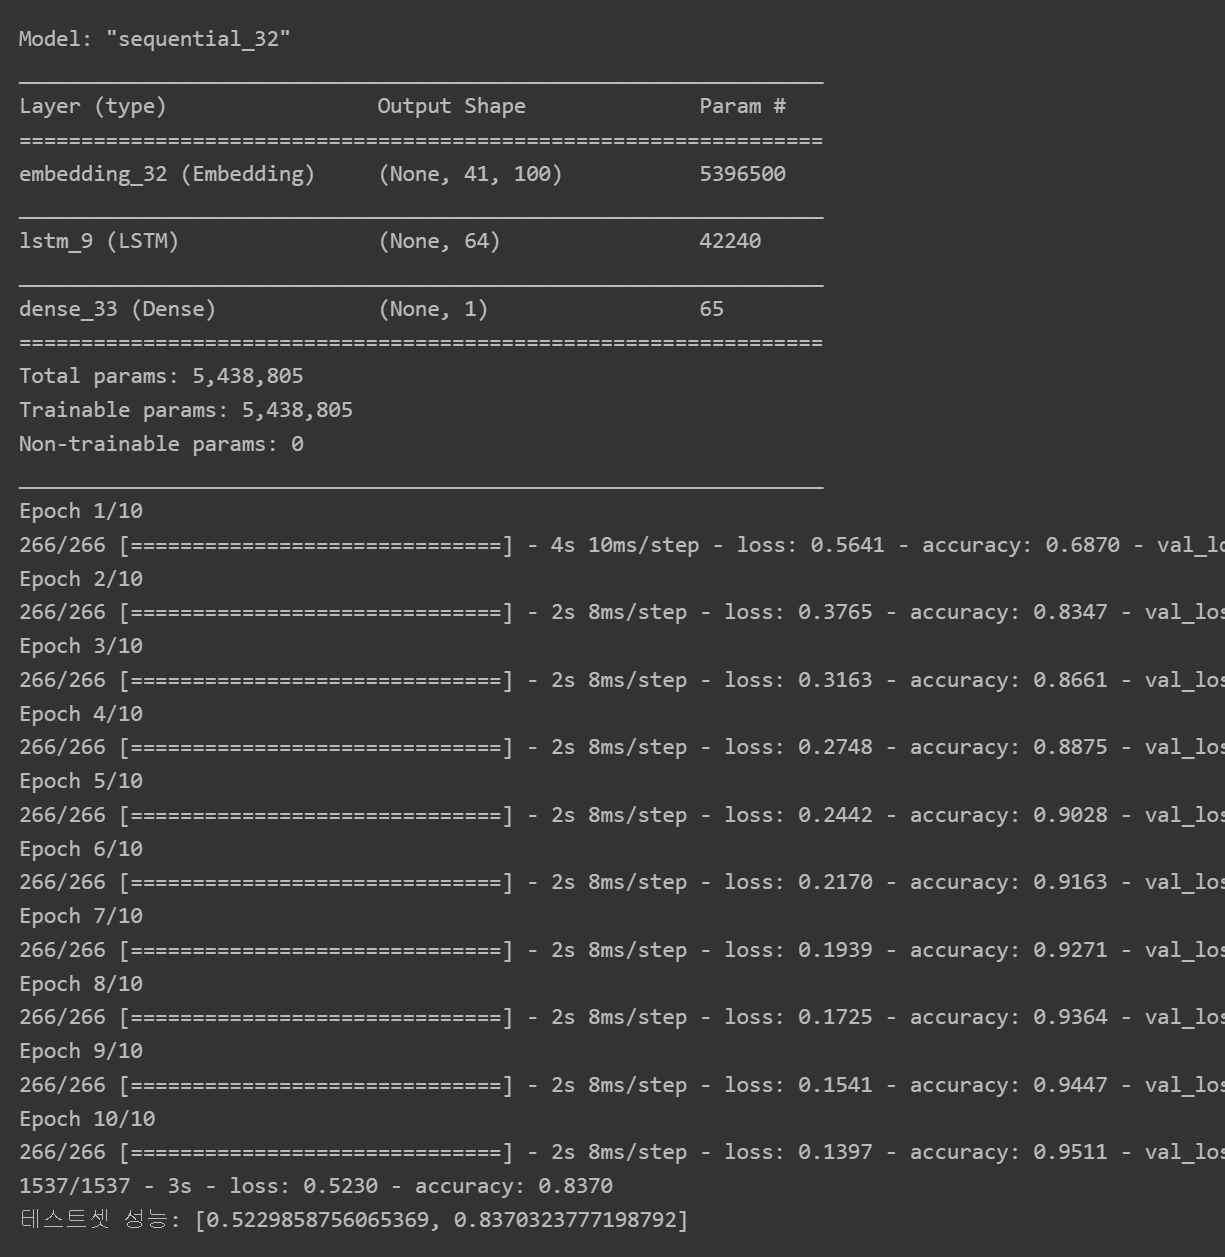

중간중간 걸리는게 생각보다 많은 노드였다.한국어판으로 하니 결측치가 이상한데서 나와 값이 데이터에 제대로 저장이 안되는게 제일
머리 아프게 했고,심볼릭링크를 걸어 모델을 가져오는것 load()사용등 생각보다 어려움이 많았다.